<h1> <center> CT5133 - Assignment 2  </center> </h1>
<h1> <center>   Unsupervised/self-supervised learning and generating images in Keras </center> </h1>
 
<h2> <center> Nehal Sitaram Malap | 21237207 | MSc. Data Analytics </center> </h2> 

### Task Description: 
The given task is to select a image dataset and apply supervised/self-supervised learning using Auto-Encoder, Variational Auto-Encoder and Generative Adversarial Network models and examine the outputs. 

### Task 1 : Selection and Pre-processing of dataset
The dataset chosen for the task is Chest X-Ray Images (Pneumonia). The link for the dataset is as follows: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia . The dataset has three classes: BACTERIAL PNEUMONIA, VIRAL PNEUMONIA and NORMAL. The dataset consists of 4148 training images and 300 test images. Since, in this assignment the training and test images are the same, both the sets are combined. 

#### Potential Applications: 
1. The regeneration of these X-Ray images can be used to visualise several surgery scenarios, if needed. 
2. These X-Ray images can be regenerated to  diagnose any potential aggravation of existing condition or future problems that could be expected. 
3. The regenerated X-ray images can also be used for medical research purposes. 

In [ ]:
#Importing the required libraries
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import keras
from tensorflow.keras import Sequential, layers, activations, models
from keras import layers
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
import cv2
from keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Importing the dataset images from the directory

#Storing the local directory of the dataset
data_dir = glob.glob('data/train/*.*')
x=[]

#Fetching images from each subdirectory
for i in data_dir:   
    image=tf.keras.preprocessing.image.load_img(i, target_size=(64,64))
    image=np.array(image)
    x.append(image)

#Converting the images to numpy array
x = np.array(x)

#Converting the images to grayscale
x_train = np.zeros(x.shape[:-1])
for i in range(x_train.shape[0]): 
    x_train[i] = cv2.cvtColor(x[i], cv2.COLOR_BGR2GRAY)

In [ ]:
#Preprocessing and creating the keras dataset from the numpy array
dataset = tf.data.Dataset.from_tensor_slices(
     x_train.reshape(4448, 4096).astype("float32") / 255.0)

#Mapping both train and test to the same data
dataset = dataset.map(lambda x: (x, x))  
dataset = dataset.shuffle(buffer_size=1024).batch(32)

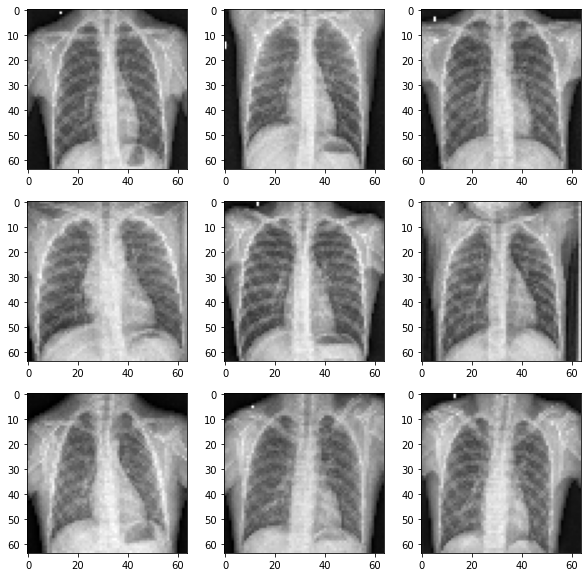

In [ ]:
#Visualising 9 sample from the dataset in a 3x3 grid
rows=3
cols = 3
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(x_train):
            axes[i, j].imshow(x_train[img_count],cmap="gray")
            img_count+=1

### Task 2 - Creating AutoEncoders, Variational Auto Encoders and Generative Adversarial Network

In this task, the Auto Encoder, Variational Auto Encoder and Generative Adversarial Network is created with the help of Keras. The created networks are then applied on the dataset selected and visualised. 

#### Function to visualise latent space:

In [ ]:
#plot_latent_space function is used to visualise the output from the encoders

#The value of n=3 is given to make sure the image is visualised in a 3x3 grid. 

def plot_latent_space(forward_fn, n=3, figsize=10):
    # display a n*n 2D manifold of digits
    image_size = 64
    scale = 3.0 
    figure = np.zeros((image_size * n, image_size * n))
    # corresponding to the 2D plot in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = forward_fn.predict(z_sample)
            digit = x_decoded[0].reshape(image_size, image_size)
            figure[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))#
    start_range = image_size // 2
    end_range = n * image_size + start_range
    pixel_range = np.arange(start_range, end_range, image_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys")
    plt.show()

### Auto Encoders using keras

In [ ]:
#Creating Auto Encoder model using keras

#This code is based on the code from the following link: 
#https://blog.keras.io/building-autoencoders-in-keras.html

#Initialise latent dimension
encoding_dim = 2

#Input image to the encoder
input_img = keras.Input(shape=(4096,))

#Encoding the image with a single dense layer with relu activation
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

#Decoding image with a single dense layee with sigmoid activation
decoded = layers.Dense(4096, activation='sigmoid')(encoded)

#Creating the autoencoder model consiting of encoder and decoder
autoencoder = keras.Model(input_img, decoded)

#Creating the encoder 
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))

#Creating the decoder
decoder_layer = autoencoder.layers[-1]

decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 2)                 8194      
                                                                 
 dense_1 (Dense)             (None, 4096)              12288     
                                                                 
Total params: 20,482
Trainable params: 20,482
Non-trainable params: 0
_________________________________________________________________


#### Result: 
The model is trained on the dataset created and the visualised with the plot_latent_space function. The mean squared error loss of the model is displayed below. The images generated from the Auto encoders seem to have more noise and hence the key features of the images are lost. However, the basic structure of the image is identifiable from the result generated

Epoch 1/5
139/139 [==============================] - 0s 1ms/step - loss: 0.0529
Epoch 2/5
139/139 [==============================] - 0s 1ms/step - loss: 0.0456
Epoch 3/5
139/139 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 4/5
139/139 [==============================] - 0s 1ms/step - loss: 0.0360
Epoch 5/5
139/139 [==============================] - 0s 1ms/step - loss: 0.0329


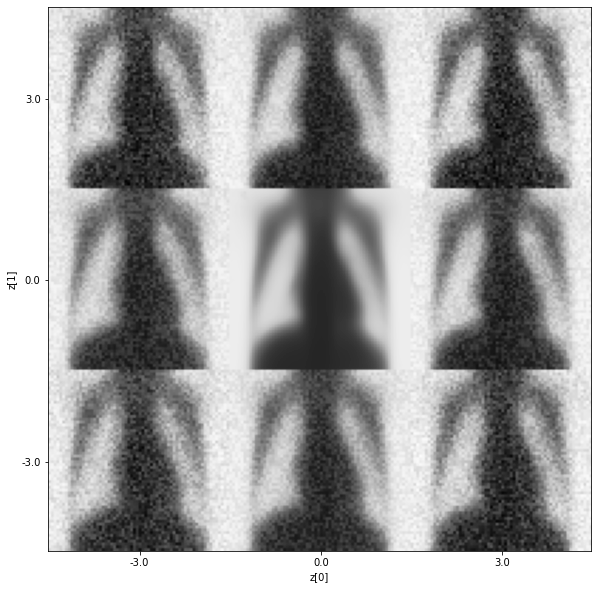

In [ ]:
#Visualising the autoencoder result
autoencoder.fit(dataset, epochs=5)
plot_latent_space(decoder)

### Variational Auto Encoder with Keras

In [ ]:
# Variational Auto-Encoder in Keras
# This code is mostly from Chollet:
# https://keras.io/getting_started/intro_to_keras_for_researchers/#endtoend-experiment-example-1-variational-autoencoders

# However, it uses the approach to creating the dual loss from:
# https://gist.github.com/tik0/6aa42cabb9cf9e21567c3deb309107b7

#Intialising the dimensions
original_dim = 4096
intermediate_dim = 64
latent_dim = 2


#Creating a class for sampling z_mean and z_log_variance by overiding the call method
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        # override the inherited .call(self, inputs) method
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean)) #N(0, 1)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


#Creating the enconder layer similar to AE, but with sampling for z_mean and z_log_variance
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")


#Creating  decoder layer similar to AE
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

#Initialising the vae model
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Loss approach from
# https://gist.github.com/tik0/6aa42cabb9cf9e21567c3deb309107b7
reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
reconstruction_loss = original_dim * K.mean(reconstruction_loss)
kl_loss = -0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

#Adding two losses to the model, kl_loss and mse_loss
vae.add_loss(kl_loss)
vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
vae.add_loss(reconstruction_loss)
vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

#initialising the adam optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#Compiling the vae model
vae.compile(optimizer)
vae.summary()


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 4096)]       0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 64)           262208      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            130         ['dense_2[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 2)            130         ['dense_2[0][0]']                
                                                                                                

#### Result:
The model is trained on the dataset created and the visualised with the plot_latent_space function. The noise in the image are comapritively lower than that of the AE encoder, however, the images seem to be too smooth and identical too one another. 

Epoch 1/5
139/139 [==============================] - 1s 3ms/step - loss: 111.7861 - kl_loss: 8.4296 - mse_loss: 103.3565
Epoch 2/5
139/139 [==============================] - 0s 3ms/step - loss: 80.5172 - kl_loss: 3.8541 - mse_loss: 76.6632
Epoch 3/5
139/139 [==============================] - 0s 3ms/step - loss: 73.6838 - kl_loss: 3.2316 - mse_loss: 70.4522
Epoch 4/5
139/139 [==============================] - 0s 3ms/step - loss: 71.1870 - kl_loss: 2.8518 - mse_loss: 68.3352
Epoch 5/5
139/139 [==============================] - 0s 3ms/step - loss: 68.9397 - kl_loss: 2.6576 - mse_loss: 66.2820


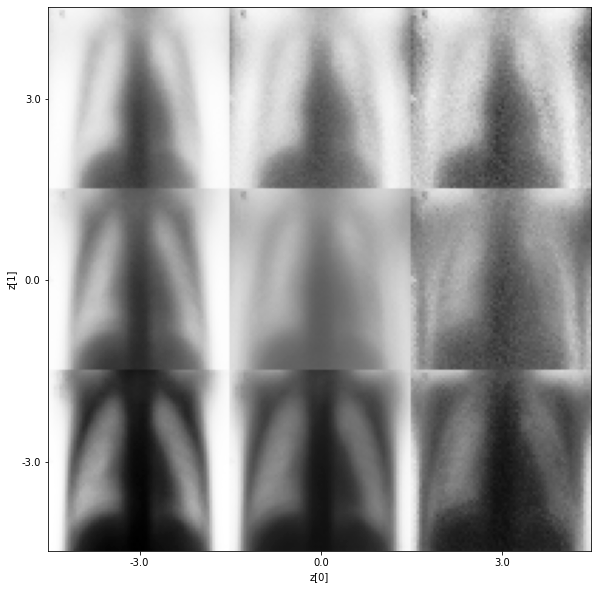

In [ ]:
#Training the vae model
vae.fit(dataset, epochs=5)

#Visualising the latent space
plot_latent_space(decoder)

### Generative Adversarial Network using Keras

In [ ]:
#The code is based on the code from https://gist.github.com/s33a11ev1l/7917feed3dd59bb3bc2efcdaa02117a3


#Initialising the image shape to be used in the network
img_shape = (64*64,)

#Intialising latent dimension
z_dim = 100

# Define generator model (like AE decoder)
G = Sequential()
G.add(Input(shape=(z_dim,)))
G.add(Dense(256))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(512))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(1024))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(np.prod(img_shape), activation="tanh"))
G.summary()

# Define discriminator model
D = Sequential()
D.add(Input(shape=(img_shape)))
D.add(Dense(512))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(256))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(1, activation='sigmoid')) # binary classification
D.summary()

# Adam with relatively low learning rate and momentum decay
D.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.0002, 0.5),
          metrics=['accuracy'])

#Discriminator is set to not-trainable, as generator creates the images in GAN
D.trainable = False
z = Input(shape=(z_dim,))
GAN = Model(z, D(G(z)))
GAN.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.0002, 0.5),
          metrics=['accuracy'])
GAN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

#### Result:
The model is trained on the dataset created and the visualised with the plot_latent_space function. The noise in the images are high in the initial batches, however they decrease as they reach the end.  

   0/889 [D 0.69, acc. (on x_real and x_fake)  50] [G 0.71, acc. (on x_fake)  54]


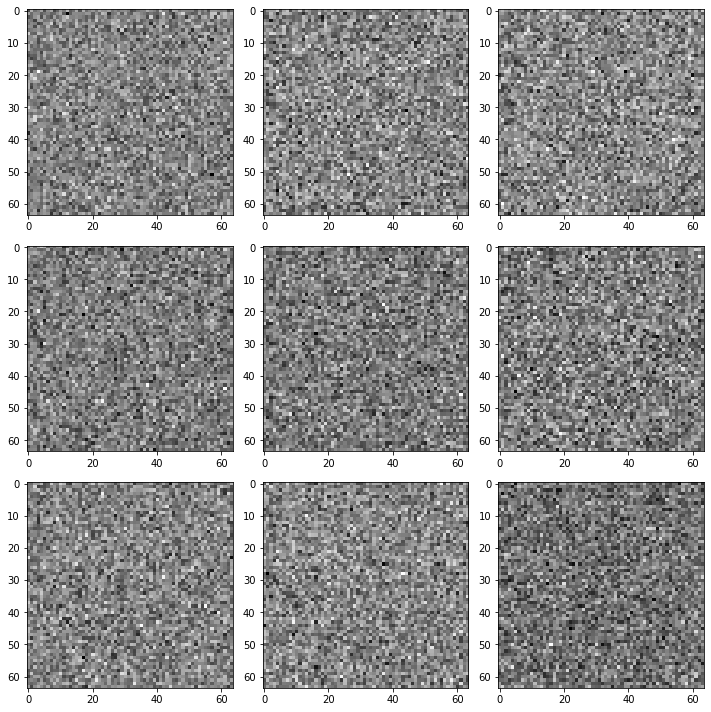

   1/889 [D 0.30, acc. (on x_real and x_fake)  99] [G 0.73, acc. (on x_fake)  50]
   2/889 [D 0.29, acc. (on x_real and x_fake)  93] [G 0.76, acc. (on x_fake)  48]
   3/889 [D 0.30, acc. (on x_real and x_fake)  90] [G 0.83, acc. (on x_fake)  44]
   4/889 [D 0.29, acc. (on x_real and x_fake)  91] [G 0.85, acc. (on x_fake)  42]
   5/889 [D 0.26, acc. (on x_real and x_fake)  95] [G 0.95, acc. (on x_fake)  32]
   6/889 [D 0.21, acc. (on x_real and x_fake)  98] [G 1.06, acc. (on x_fake)  28]
   7/889 [D 0.17, acc. (on x_real and x_fake) 100] [G 1.17, acc. (on x_fake)   8]
   8/889 [D 0.16, acc. (on x_real and x_fake) 100] [G 1.28, acc. (on x_fake)  10]
   9/889 [D 0.13, acc. (on x_real and x_fake)  99] [G 1.38, acc. (on x_fake)   4]
  10/889 [D 0.13, acc. (on x_real and x_fake) 100] [G 1.50, acc. (on x_fake)   0]
  11/889 [D 0.10, acc. (on x_real and x_fake) 100] [G 1.62, acc. (on x_fake)   0]
  12/889 [D 0.10, acc. (on x_real and x_fake) 100] [G 1.79, acc. (on x_fake)   0]
  13/889 [D 0.12

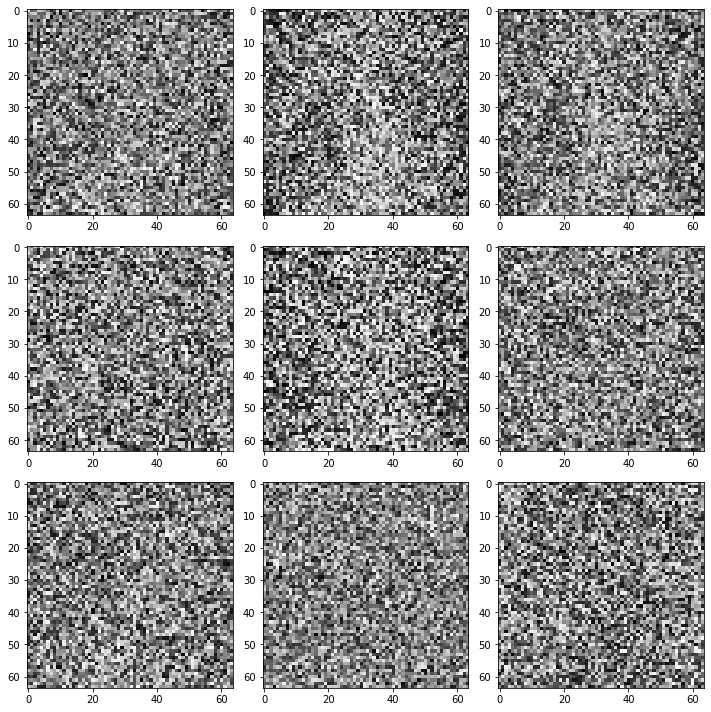

 101/889 [D 0.05, acc. (on x_real and x_fake)  98] [G 4.60, acc. (on x_fake)   0]
 102/889 [D 0.39, acc. (on x_real and x_fake)  98] [G 4.17, acc. (on x_fake)   0]
 103/889 [D 0.06, acc. (on x_real and x_fake)  99] [G 4.50, acc. (on x_fake)   0]
 104/889 [D 0.03, acc. (on x_real and x_fake) 100] [G 4.76, acc. (on x_fake)   0]
 105/889 [D 0.04, acc. (on x_real and x_fake) 100] [G 4.99, acc. (on x_fake)   0]
 106/889 [D 0.06, acc. (on x_real and x_fake)  99] [G 4.53, acc. (on x_fake)   0]
 107/889 [D 0.03, acc. (on x_real and x_fake) 100] [G 4.77, acc. (on x_fake)   0]
 108/889 [D 0.03, acc. (on x_real and x_fake) 100] [G 4.98, acc. (on x_fake)   0]
 109/889 [D 0.05, acc. (on x_real and x_fake)  97] [G 5.14, acc. (on x_fake)   0]
 110/889 [D 0.05, acc. (on x_real and x_fake)  99] [G 5.52, acc. (on x_fake)   0]
 111/889 [D 0.05, acc. (on x_real and x_fake)  99] [G 5.10, acc. (on x_fake)   0]
 112/889 [D 0.02, acc. (on x_real and x_fake) 100] [G 5.08, acc. (on x_fake)   0]
 113/889 [D 0.03

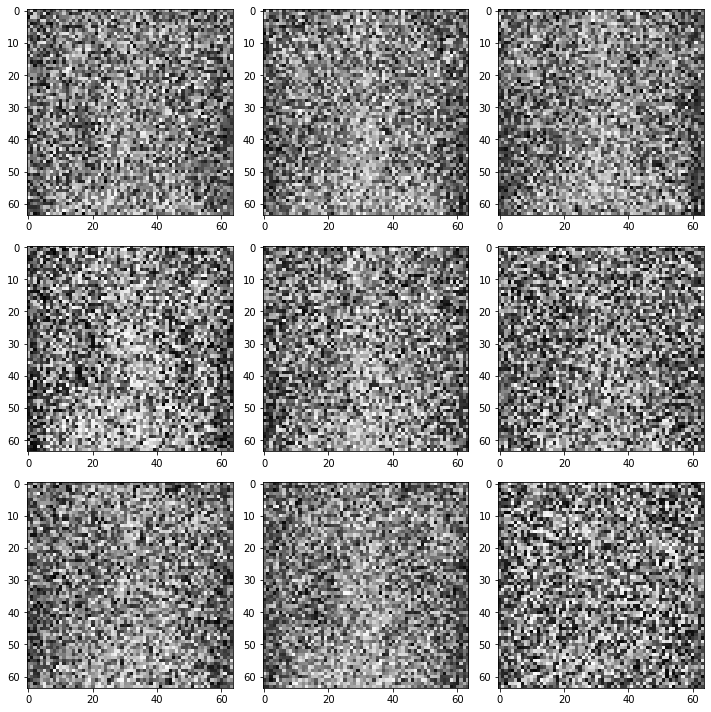

 201/889 [D 0.13, acc. (on x_real and x_fake)  97] [G 4.40, acc. (on x_fake)   0]
 202/889 [D 0.08, acc. (on x_real and x_fake) 100] [G 3.78, acc. (on x_fake)   0]
 203/889 [D 0.10, acc. (on x_real and x_fake)  99] [G 4.04, acc. (on x_fake)   0]
 204/889 [D 0.28, acc. (on x_real and x_fake)  90] [G 3.45, acc. (on x_fake)   0]
 205/889 [D 0.11, acc. (on x_real and x_fake)  95] [G 4.82, acc. (on x_fake)   0]
 206/889 [D 1.83, acc. (on x_real and x_fake)  40] [G 0.76, acc. (on x_fake)  66]
 207/889 [D 0.61, acc. (on x_real and x_fake)  67] [G 2.90, acc. (on x_fake)   6]
 208/889 [D 0.25, acc. (on x_real and x_fake)  88] [G 3.47, acc. (on x_fake)   0]
 209/889 [D 0.29, acc. (on x_real and x_fake)  89] [G 2.88, acc. (on x_fake)   2]
 210/889 [D 0.13, acc. (on x_real and x_fake)  96] [G 3.66, acc. (on x_fake)   0]
 211/889 [D 0.10, acc. (on x_real and x_fake)  99] [G 3.89, acc. (on x_fake)   0]
 212/889 [D 0.10, acc. (on x_real and x_fake) 100] [G 3.41, acc. (on x_fake)   0]
 213/889 [D 0.10

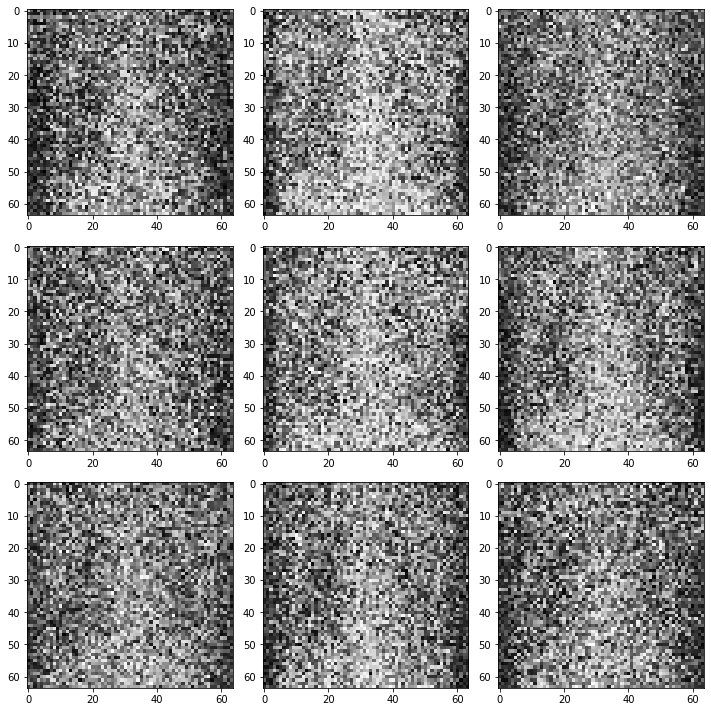

 301/889 [D 0.60, acc. (on x_real and x_fake)  65] [G 1.63, acc. (on x_fake)   6]
 302/889 [D 0.45, acc. (on x_real and x_fake)  76] [G 2.73, acc. (on x_fake)   0]
 303/889 [D 0.53, acc. (on x_real and x_fake)  76] [G 2.18, acc. (on x_fake)   0]
 304/889 [D 0.35, acc. (on x_real and x_fake)  90] [G 2.97, acc. (on x_fake)   0]
 305/889 [D 0.62, acc. (on x_real and x_fake)  64] [G 1.75, acc. (on x_fake)   2]
 306/889 [D 0.39, acc. (on x_real and x_fake)  80] [G 2.88, acc. (on x_fake)   0]
 307/889 [D 0.64, acc. (on x_real and x_fake)  61] [G 1.64, acc. (on x_fake)   6]
 308/889 [D 0.40, acc. (on x_real and x_fake)  83] [G 2.87, acc. (on x_fake)   0]
 309/889 [D 0.64, acc. (on x_real and x_fake)  65] [G 1.66, acc. (on x_fake)   4]
 310/889 [D 0.30, acc. (on x_real and x_fake)  93] [G 2.93, acc. (on x_fake)   0]
 311/889 [D 0.93, acc. (on x_real and x_fake)  51] [G 0.98, acc. (on x_fake)  36]
 312/889 [D 0.47, acc. (on x_real and x_fake)  71] [G 2.15, acc. (on x_fake)   4]
 313/889 [D 0.49

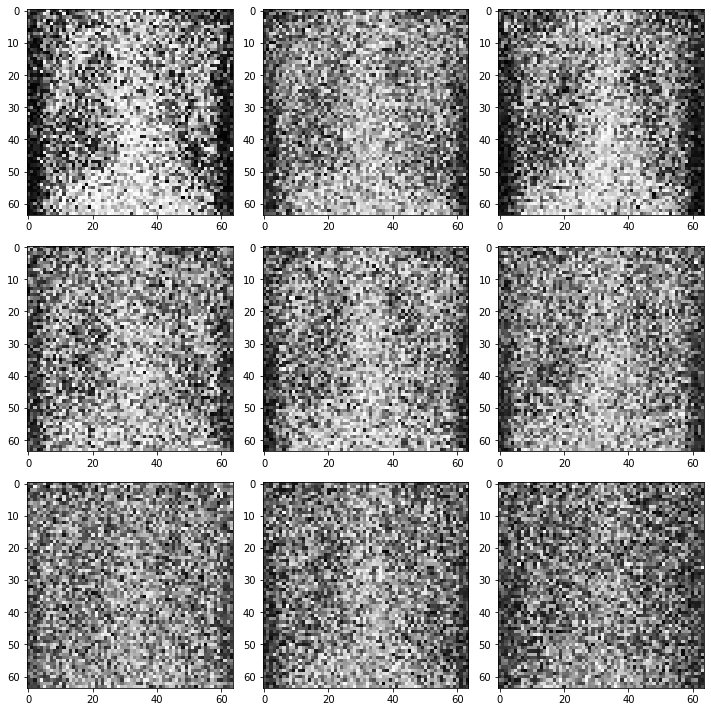

 401/889 [D 0.62, acc. (on x_real and x_fake)  62] [G 1.32, acc. (on x_fake)   0]
 402/889 [D 0.57, acc. (on x_real and x_fake)  74] [G 1.38, acc. (on x_fake)   0]
 403/889 [D 0.65, acc. (on x_real and x_fake)  60] [G 1.38, acc. (on x_fake)   0]
 404/889 [D 0.62, acc. (on x_real and x_fake)  65] [G 1.47, acc. (on x_fake)   0]
 405/889 [D 0.73, acc. (on x_real and x_fake)  49] [G 1.25, acc. (on x_fake)   2]
 406/889 [D 0.53, acc. (on x_real and x_fake)  78] [G 1.54, acc. (on x_fake)   0]
 407/889 [D 0.64, acc. (on x_real and x_fake)  64] [G 1.19, acc. (on x_fake)   0]
 408/889 [D 0.57, acc. (on x_real and x_fake)  71] [G 1.35, acc. (on x_fake)   0]
 409/889 [D 0.65, acc. (on x_real and x_fake)  61] [G 1.61, acc. (on x_fake)   0]
 410/889 [D 0.61, acc. (on x_real and x_fake)  65] [G 1.39, acc. (on x_fake)   4]
 411/889 [D 0.55, acc. (on x_real and x_fake)  74] [G 1.26, acc. (on x_fake)   4]
 412/889 [D 0.62, acc. (on x_real and x_fake)  66] [G 1.30, acc. (on x_fake)   0]
 413/889 [D 0.52

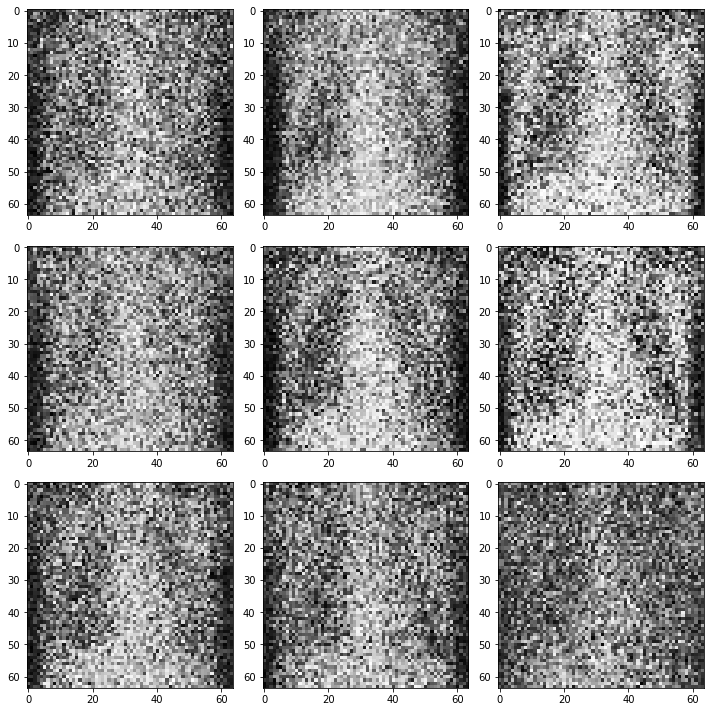

 501/889 [D 0.67, acc. (on x_real and x_fake)  61] [G 1.10, acc. (on x_fake)   2]
 502/889 [D 0.68, acc. (on x_real and x_fake)  54] [G 1.01, acc. (on x_fake)   4]
 503/889 [D 0.66, acc. (on x_real and x_fake)  56] [G 1.13, acc. (on x_fake)   0]
 504/889 [D 0.68, acc. (on x_real and x_fake)  61] [G 1.05, acc. (on x_fake)   2]
 505/889 [D 0.66, acc. (on x_real and x_fake)  63] [G 1.00, acc. (on x_fake)   0]
 506/889 [D 0.64, acc. (on x_real and x_fake)  63] [G 1.04, acc. (on x_fake)   0]
 507/889 [D 0.69, acc. (on x_real and x_fake)  53] [G 1.07, acc. (on x_fake)   0]
 508/889 [D 0.63, acc. (on x_real and x_fake)  63] [G 0.99, acc. (on x_fake)   8]
 509/889 [D 0.70, acc. (on x_real and x_fake)  48] [G 0.99, acc. (on x_fake)   4]
 510/889 [D 0.63, acc. (on x_real and x_fake)  62] [G 1.11, acc. (on x_fake)   0]
 511/889 [D 0.68, acc. (on x_real and x_fake)  55] [G 1.04, acc. (on x_fake)   2]
 512/889 [D 0.67, acc. (on x_real and x_fake)  56] [G 1.04, acc. (on x_fake)   0]
 513/889 [D 0.66

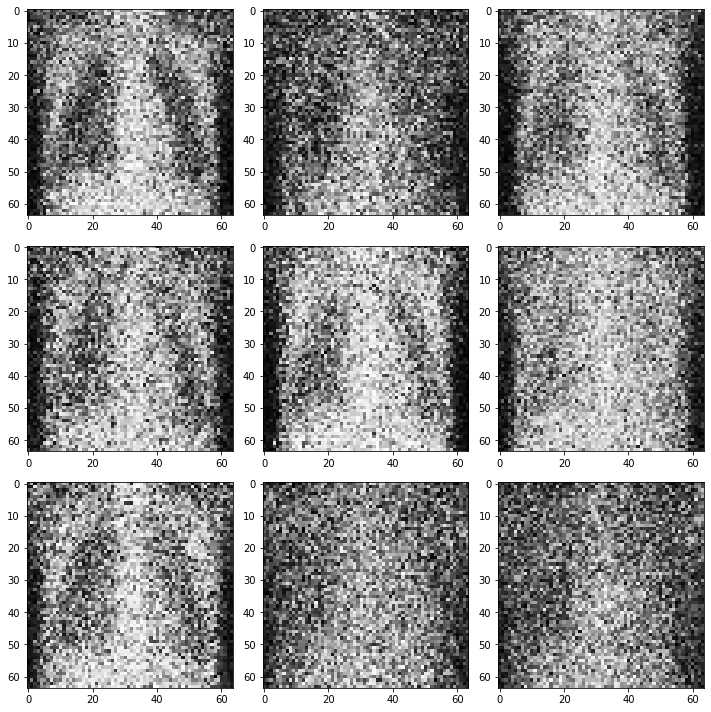

 601/889 [D 0.70, acc. (on x_real and x_fake)  51] [G 1.06, acc. (on x_fake)   0]
 602/889 [D 0.71, acc. (on x_real and x_fake)  49] [G 0.98, acc. (on x_fake)   2]
 603/889 [D 0.69, acc. (on x_real and x_fake)  57] [G 0.96, acc. (on x_fake)   0]
 604/889 [D 0.68, acc. (on x_real and x_fake)  52] [G 0.98, acc. (on x_fake)   0]
 605/889 [D 0.67, acc. (on x_real and x_fake)  61] [G 1.01, acc. (on x_fake)   0]
 606/889 [D 0.68, acc. (on x_real and x_fake)  55] [G 1.01, acc. (on x_fake)   2]
 607/889 [D 0.67, acc. (on x_real and x_fake)  56] [G 0.97, acc. (on x_fake)   2]
 608/889 [D 0.69, acc. (on x_real and x_fake)  49] [G 1.00, acc. (on x_fake)   0]
 609/889 [D 0.65, acc. (on x_real and x_fake)  67] [G 0.96, acc. (on x_fake)   6]
 610/889 [D 0.65, acc. (on x_real and x_fake)  63] [G 0.95, acc. (on x_fake)  16]
 611/889 [D 0.67, acc. (on x_real and x_fake)  54] [G 1.00, acc. (on x_fake)   8]
 612/889 [D 0.69, acc. (on x_real and x_fake)  50] [G 0.98, acc. (on x_fake)   0]
 613/889 [D 0.68

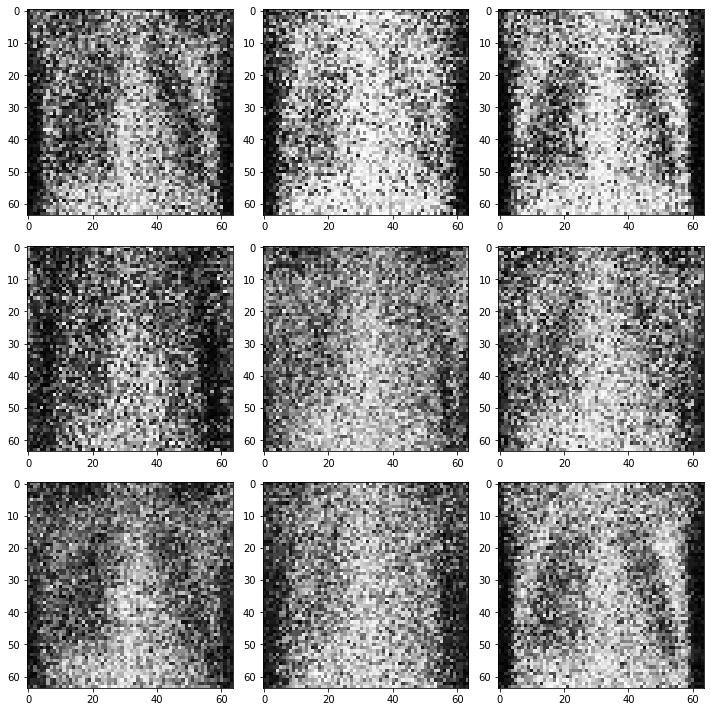

 701/889 [D 0.69, acc. (on x_real and x_fake)  53] [G 0.92, acc. (on x_fake)   2]
 702/889 [D 0.65, acc. (on x_real and x_fake)  63] [G 0.93, acc. (on x_fake)   6]
 703/889 [D 0.68, acc. (on x_real and x_fake)  62] [G 0.92, acc. (on x_fake)   4]
 704/889 [D 0.70, acc. (on x_real and x_fake)  47] [G 0.91, acc. (on x_fake)   6]
 705/889 [D 0.72, acc. (on x_real and x_fake)  48] [G 0.92, acc. (on x_fake)   8]
 706/889 [D 0.67, acc. (on x_real and x_fake)  60] [G 0.90, acc. (on x_fake)  10]
 707/889 [D 0.69, acc. (on x_real and x_fake)  53] [G 0.94, acc. (on x_fake)   4]
 708/889 [D 0.69, acc. (on x_real and x_fake)  47] [G 0.93, acc. (on x_fake)   0]
 709/889 [D 0.70, acc. (on x_real and x_fake)  47] [G 0.88, acc. (on x_fake)   2]
 710/889 [D 0.67, acc. (on x_real and x_fake)  57] [G 0.90, acc. (on x_fake)  12]
 711/889 [D 0.67, acc. (on x_real and x_fake)  52] [G 0.92, acc. (on x_fake)  14]
 712/889 [D 0.70, acc. (on x_real and x_fake)  48] [G 0.92, acc. (on x_fake)   2]
 713/889 [D 0.69

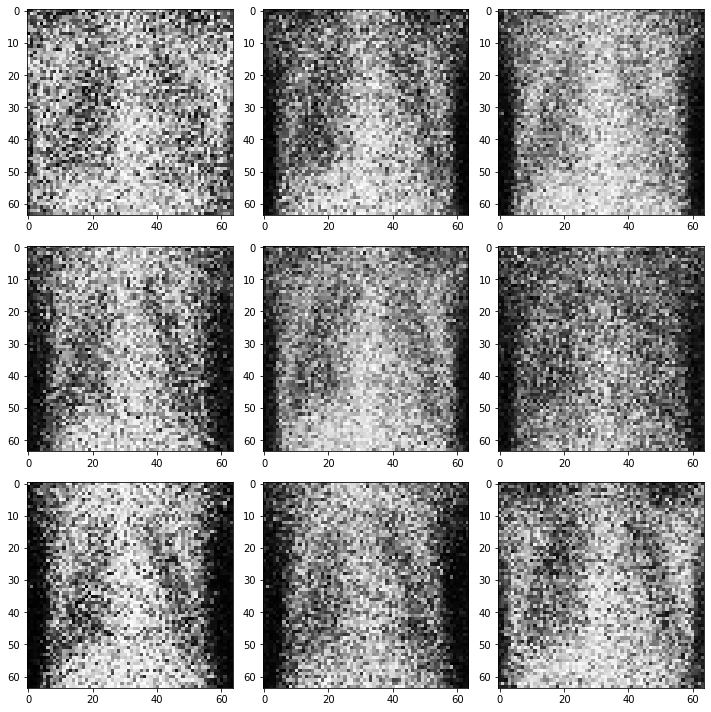

 801/889 [D 0.71, acc. (on x_real and x_fake)  56] [G 0.91, acc. (on x_fake)  10]
 802/889 [D 0.70, acc. (on x_real and x_fake)  51] [G 0.92, acc. (on x_fake)   8]
 803/889 [D 0.70, acc. (on x_real and x_fake)  57] [G 0.92, acc. (on x_fake)   0]
 804/889 [D 0.75, acc. (on x_real and x_fake)  39] [G 0.88, acc. (on x_fake)   2]
 805/889 [D 0.68, acc. (on x_real and x_fake)  58] [G 0.94, acc. (on x_fake)   4]
 806/889 [D 0.70, acc. (on x_real and x_fake)  47] [G 0.94, acc. (on x_fake)   0]
 807/889 [D 0.66, acc. (on x_real and x_fake)  59] [G 0.91, acc. (on x_fake)   8]
 808/889 [D 0.71, acc. (on x_real and x_fake)  45] [G 0.96, acc. (on x_fake)   6]
 809/889 [D 0.67, acc. (on x_real and x_fake)  62] [G 1.00, acc. (on x_fake)   2]
 810/889 [D 0.74, acc. (on x_real and x_fake)  49] [G 0.89, acc. (on x_fake)   6]
 811/889 [D 0.67, acc. (on x_real and x_fake)  63] [G 0.93, acc. (on x_fake)   4]
 812/889 [D 0.73, acc. (on x_real and x_fake)  38] [G 0.94, acc. (on x_fake)   0]
 813/889 [D 0.69

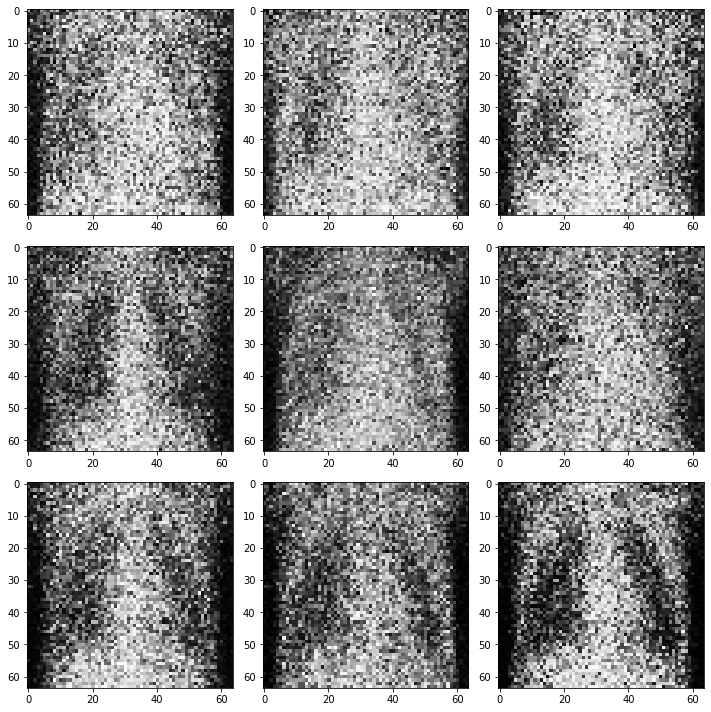

In [ ]:
# map to range [-1, 1]: suitable for tanh
x_train = x_train / 127.5 - 1. 
x_train = x_train.reshape(x_train.shape[0], 64*64)

#Intialising epoch, batch_size, steps and interval
batch_size=50
epochs = 10
steps = epochs * x_train.shape[0] // batch_size
sample_interval=100

#Creating numpy array of 1 and 0 for fake and real respectively
y_fake = np.ones((batch_size, 1))
y_real = np.zeros((batch_size, 1))

#Function to apply the GAN to predict and plot the images in a 3x3 grid
def sample_images(epoch):
    # save an image to see some of our fake images
    r, c = 3,3
    z = np.random.normal(0, 1, (r * c, z_dim))
    x_fake = G.predict(z)

    fig, axs = plt.subplots(r, c, figsize=(10,10))
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(x_fake[i*r+j].reshape((64,64)), cmap='gray')
            axs[i, j].axis('on')
    plt.tight_layout()
    plt.show()
    plt.close()


#Training the GAN model created with losses
for step in range(steps):

    # choose real images, x_real, and make fake images, x_fake
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    x_real = x_train[idx]
    z = np.random.normal(0, 1, (batch_size, z_dim))
    x_fake = G.predict(z)

    # train D
    loss_d_real = D.train_on_batch(x_real, y_real)
    loss_d_fake = D.train_on_batch(x_fake, y_fake)
    loss_d = 0.5 * np.add(loss_d_real, loss_d_fake)

    # pass y_real, ie pretend these images are real
    loss_g = GAN.train_on_batch(z, y_real)

    print(f"{step:4d}/{steps} [D {loss_d[0]:.2f}, acc. (on x_real and x_fake) {100 * loss_d[1]:3.0f}] [G {loss_g[0]:.2f}, acc. (on x_fake) {100 * loss_g[1]:3.0f}]")
    if step % sample_interval == 0 or step == steps - 1:
        sample_images(step)

### Result Comparison and Discussion:

By Comparing the results of the three models, the Variational Auto Encoder produce a comparitively good regeneration of the images compared to the auto-encoders and the generative adversarial network. The noise in the generated images seem to be greater on auto-encoders and in the initial batches of the generative adversarial netowrk. However the image quality increases as the generative adversarial network progresses. The mse loss and accuracy of each of these models, are indicative of the image quality of each of these models. The quality of the images produced can be improved by the addition of Convolutional layers in the models. This might also be due to the similar nature of the image dataset used and the comparitively less number of images used to train than usual. 